In [1]:
from ipynb.fs.full.Introduction import *
from tqdm import tqdm
import time

# Simplified Graph Convolution(al Networks)

Wu et. al. (2019) introduced the Simplified Graph Convolution (SGC) [17]

$$X^{out} = \Theta{}(A^{k}X^{in})$$

In practice, they found that removing the non-linearities at each GCN layer did not impact classification accuracy whilst greatly reducing the parameter count. Since learning Katz Centrality for low-density networks seemingly requires deeper (and thus more expensive) models, we felt it prudent to do some experiments. 

## Model and Dataset

In [2]:
num_graphs = 3000
d = []
for _ in range(num_graphs):
    n = torch.randint(50,100,(5,))
    p = 1/(50*n) + (49/(50*n)) * torch.rand((5,5))
    p = .5 * (p + p.T)
    x,edges = torch.ones((n.sum(),1)),torch_geometric.utils.remove_isolated_nodes(torch_geometric.utils.stochastic_blockmodel_graph(n,p))[0]
    adj = torch_sparse.SparseTensor(row=edges[0],col=edges[1])

    d.append(torch_geometric.data.Data(x=x[:adj.size(0)],edge_index = edges))

for idx,G in enumerate(d):
    G.edge_weight = torch.ones(G.edge_index[0].shape)
    adj = torch_sparse.SparseTensor(row=G.edge_index[0],col=G.edge_index[1],value=G.edge_weight)
    v = 1/(1.01*torch.norm(torch.eig(adj.to_dense())[0],dim=1).max())
    y = torch.sum(torch.inverse(torch.eye(adj.size(0)) - v*adj.to_dense().T) - torch.eye(adj.size(0)),dim=1)
    G.y = y
    d[idx] = G
    
train,test = d[:2000],d[2000::]
train_loader = torch_geometric.data.DataLoader(train,batch_size=200,shuffle=True)
test_loader = torch_geometric.data.DataLoader(test,batch_size=200,shuffle=True)

In [3]:
class SGC(torch.nn.Module):
    def __init__(self,in_channels,int_channels,out_channels,k=2):
        super(SGC,self).__init__()

        self.finish = torch.nn.Sequential(*[torch.nn.Linear(1,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,out_channels)])
        self.k = k

    def forward(self,X,edge_index,edge_weight,batch):
        for _ in range(self.k):
              X = torch_scatter.scatter_sum(edge_weight[:,None] * X[edge_index[1]],edge_index[0],dim=0)
              X = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
        return self.finish(X)

In [4]:
results = []

torch.manual_seed(0)
for k in [1,2,4,8,16,32,64]:
    model = SGC(1,32,1,k).cuda()
    
    results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
    torch.cuda.empty_cache()

## Results

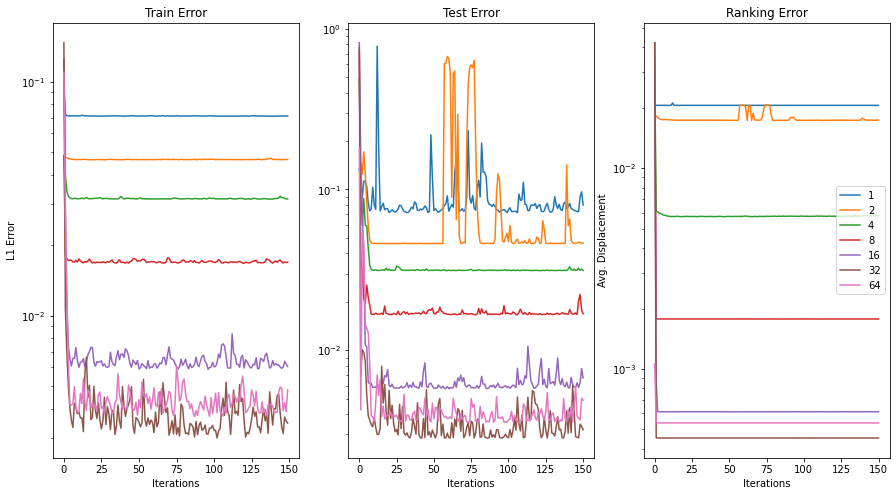

In [5]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(results[idx][0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(results[idx][1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(results[idx][2],label=k)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.show()

Above $l=8$, test loss and rank displacement are lower than for GraphConv models of similar depth. Convergence is also much faster, and, with regards to practicality, SGC takes half the time to train.

## PolynomialSGC

If matrix $A$ has eigenpairs $(\lambda_{i},v_{i})$, $p(A)$ (for some polynomial $p$) possesses eigenpairs $(p(\lambda_{i}),v_{i})$. SGC uses $p(A) = A^{k}$, as all except the final matrix power are discarded. But it is often possible to choose a more efficient polynomial, in the sense that $\frac{|p(\lambda_{2})|}{|p(\lambda_{1})|}\leq{}(\frac{|\lambda_{2}|}{|\lambda_{1}|})^{k}$. To this end, we propose an extension of SGC, PolynomialSGC:

$$c^{1}_{i} = \frac{e^{c^{1}_{i}}}{\sum_{i=0}^{k}e^{c^{1}_{i}}} \; \; \; \; c^{2}_{i} = \frac{e^{c^{2}_{i}}}{\sum_{i=0}^{k}e^{c^{2}_{i}}}$$
$$X^{out} = \Theta{}((c^{2}_{k}-c^{1}_{k})A^{k}X^{in} + (c^{2}_{k-1}-c^{1}_{k-1})A^{k-1}X^{in} + ... + (c^{2}_{0}-c^{1}_{0})X^{in})$$


### Model

In [9]:
class PolynomialSGC(torch.nn.Module):
    def __init__(self,in_channels,int_channels,out_channels,k=2):
        super(PolynomialSGC,self).__init__()
        self.coefficients = torch.nn.Sequential(*[torch.nn.Linear(k,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,k+1)])
        self.finish = torch.nn.Sequential(*[torch.nn.Linear(1,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,out_channels)])
        self.k = k

    def forward(self,X,edge_index,edge_weight,batch):
        X = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
        
        Z = X.unsqueeze(1)
        
        for idx in range(self.k):
            nX = torch_scatter.scatter_sum(edge_weight[:,None] * X[edge_index[1]],edge_index[0],dim=0)
            
            rayleigh = torch_scatter.scatter_sum(nX * X,batch, dim=0)/torch_scatter.scatter_sum(X**2,batch,dim=0)
            if idx==0:
                C = rayleigh
            else:
                C = torch.cat((C,rayleigh),dim=1)
                
            X = nX/torch_scatter.scatter_sum(nX**2,batch,dim=0).sqrt()[batch]
            Z = torch.cat((Z,X.unsqueeze(1)),dim=1)
            
        C = C[1::]/C[:-1]
        C = torch.nn.Softmax(dim=1)(self.coefficients(C))
        Z = torch.sum(C[batch,:,None] * Z,dim=1)
        return self.finish(Z)

In [12]:
results = []

torch.manual_seed(0)
for k in [1,2,4,8,16,32,64]:
    model = PolynomialSGC(1,32,1,k)
    
    results.append(train_loop(model,train_loader,test_loader,50,lr=1e-1))
    torch.cuda.empty_cache()

RuntimeError: CUDA error: device-side assert triggered

In [7]:
torch.cuda.empty_cache()

RuntimeError: CUDA error: device-side assert triggered

### Results

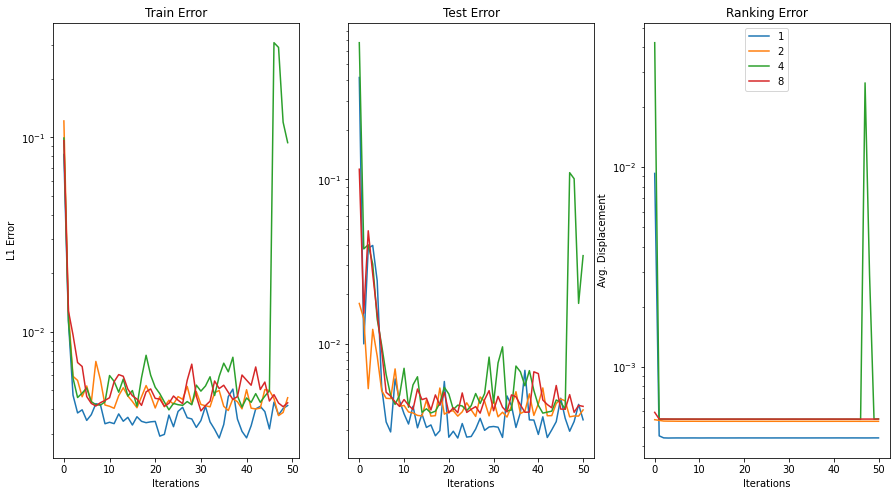

In [25]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for idx,k in enumerate([1,2,4,8]):
    plt.semilogy(results[idx][0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for idx,k in enumerate([1,2,4,8]):
    plt.semilogy(results[idx][1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,k in enumerate([1,2,4,8]):
    plt.semilogy(results[idx][2],label=k)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.show()

Train and test loss are slightly improved from base SGC. Rank displacement benefits the most, and change is especially notable in the $l=64$ case.

## MixHop

We also examine a single-layer MixHop model as introduced in El-Haija et. al. (2019). Taking similar inspiration from SGC, MixHop concatenates each level of aggreation into a single feature vector [18]. 
$$X^{out} = \Theta{}(A^{k}X^{in} || A^{k-1}X^{in} || ... || X^{in})$$


### Model

In [9]:
class MixHop(torch.nn.Module):
    def __init__(self,in_channels,int_channels,out_channels,k=2):
        super(MixHop,self).__init__()
        self.finish = torch.nn.Sequential(*[torch.nn.Linear(k+1,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,int_channels),torch.nn.LeakyReLU(),torch_geometric.nn.BatchNorm(int_channels),
                                            torch.nn.Linear(int_channels,out_channels)])
        self.k = k

    def forward(self,X,edge_index,edge_weight,batch):
        X = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
        Z = X
        for idx in range(self.k):
              X = torch_scatter.scatter_sum(edge_weight[:,None] * X[edge_index[1]],edge_index[0],dim=0)
              X = X/torch_scatter.scatter_sum(X**2,batch,dim=0).sqrt()[batch]
              Z = torch.cat((Z,X),dim=1)
        return self.finish(Z)

In [10]:
results = []

torch.manual_seed(0)
for k in [1,2,4,8,16,32,64]:
    model = MixHop(1,32,1,k).cuda()
    
    results.append(train_loop(model,train_loader,test_loader,150,lr=1e-1))
    torch.cuda.empty_cache()

KeyboardInterrupt: 

### Results

In [ ]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(results[idx][0])
plt.title('Train Error')
plt.ylabel('L1 Error')
plt.xlabel('Iterations')

plt.subplot(1,3,2)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(results[idx][1])
plt.title('Test Error')
plt.xlabel('Iterations')

plt.subplot(1,3,3)
for idx,k in enumerate([1,2,4,8,16,32,64]):
    plt.semilogy(results[idx][2],label=k)
plt.title('Ranking Error')
plt.ylabel('Avg. Displacement')
plt.xlabel('Iterations')
plt.legend()

plt.show()

In general, we've found attention-style GCNs to work rather poorly; they tend to exhbit greater variance in the loss, and MixHop is no exception. Even for small $k$, the test loss and displacement can be erratic. The averages are on par with PolynomialSGC (if marginally worse), but the inconsistency is no less concerning.